In [3]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
import pandas as pd
import json
from numpy import arange
from tqdm import tqdm
import itertools
import os 
import fiftyone as fo
import cv2
import fiftyone.brain as fob
import random
from fiftyone import ViewField as F
import torch                                                                                                                              
import torchvision
from PIL import Image
from torchvision.transforms import functional as func
import dill as pickle
from PIL import ImageStat
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [22]:
def load_data(path):

    # load json data
    with open(path, newline='') as jsonfile:
        data = json.load(jsonfile)

    # trans image data to df
    images_df = []
    for item in data['images']:
        images_df.append(item)
    images_df = pd.DataFrame(images_df)

    # trans annotation data to df
    annotations_df = []
    for item in data['annotations']:
        annotations_df.append(item)
    annotations_df = pd.DataFrame(annotations_df)

    filter1 = (annotations_df['category_id'] != 10)&(annotations_df['category_id'] != 11)
    annotations_df = annotations_df.loc[filter1]

    # get unique image id
    img_dup = annotations_df["image_id"].drop_duplicates()

    # filter annotated image
    filter = images_df['id'].isin(list(img_dup))
    filtered_images_df = images_df.loc[filter].set_index(arange(1,len(img_dup)+1)).rename(columns={'id':'image_id'})
    
    #paste annotation and image together
    together = pd.merge(annotations_df, filtered_images_df, on='image_id')

    # trans categories data to df and delete front_road_seg & cone
    categories_df = []
    for item in data['categories']:
        categories_df.append(item)
    categories_df = pd.DataFrame(categories_df)
    categories_df['name_index'] = categories_df['name']
    categories_df = categories_df.set_index('name_index')
    categories_df = categories_df.drop(['front_road_seg', 'cone'], axis=0)

    #load licenses
    licenses_df = data['licenses']

    #load info
    info_df = data['info']

    #load cate
    categories_change = categories_df[['id', 'name', 'supercategory']]
    categories_jnos = categories_change.to_json(orient = 'records')
    categories_jnos = json.loads(categories_jnos)

    #trun image to json
    image_change = together[['image_id','width','height','file_name','license','flickr_url','coco_url','date_captured']].rename(columns={'image_id':'id'}).drop_duplicates()
    image_json = image_change.to_json(orient = 'records')
    image_json = json.loads(image_json)

    #trun annotation to json
    annotation_change = together[['id','image_id','category_id','segmentation','area','bbox','iscrowd','attributes']]
    annotation_jnos = annotation_change.to_json(orient = 'records')
    annotation_jnos = json.loads(annotation_jnos)
 
    #make a empety json
    jsontext = {'licenses':licenses_df, 'info':info_df, 'categories':categories_jnos, 'images':image_json, 'annotations':annotation_jnos}


    # Merge annotation for BDD categories
    def merge_BDD_annotations(json_obj):
        annos = json_obj["annotations"]

        new_categories = [
            {"supercategory": "human", "id": 1, "name": "pedestrian-rider"},
            {"supercategory": "vehicle", "id": 2, "name": "car"},
            {"supercategory": "vehicle", "id": 3, "name": "truck-bus-train"},
            {"supercategory": "bike", "id": 4, "name": "motorcycle-bicycle"},
            {"supercategory": "traffic light", "id": 5, "name": "traffic light"},
            {"supercategory": "traffic sign", "id": 6, "name": "traffic sign"}]
        json_obj["categories"] = new_categories

        def merge(label):
            return {
                1: 1,  # Pedestrian
                2: 1,  # rider
                3: 2,  # car
                4: 3,  # truck
                5: 3,  # bus
                6: 3,  # rail_car
                7: 4,  # motorcycle
                8: 4,  # bicycle
                9: 5,  # traffic light
                12: 6, # sign
                
            }[label]

        for anno in tqdm(annos):
            category = anno['category_id']
            anno['category_id'] = merge(category)

        return json_obj

    text = merge_BDD_annotations(jsontext)

    #dump
    out_file = open("restore.json", "w") 
    json.dump(text, out_file, indent=4)
    out_file.close()


In [23]:
load_data('168/annotations/instances_default.json')

100%|██████████| 49925/49925 [00:00<00:00, 1151907.34it/s]


In [6]:
def img_delete(name, data_path, labels_path):
    name = name
    data_path = data_path
    labels_path = labels_path

    # Import dataset by explicitly providing paths to the source media and labels
    dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path,
        labels_path=labels_path,
        name=name
    )

    dataset = fo.load_dataset('BSD')

    # Generate visualization for image
    results = fob.compute_visualization(dataset, method='tsne')

    # open a file, where you want to store the data
    file = open('embedding', 'wb')

    # dump information to that file
    pickle.dump(results, file, pickle.HIGHEST_PROTOCOL)

    # close the file
    file.close()

    # Load
    with open('embedding', 'rb') as f:
        results_import = pickle.load(f)

    results_duplicate = results_import.serialize()

    points = []
    for item in results_duplicate['points']:
        points.append(item)
    points = pd.DataFrame(points)

    uni = []
    for i in range(len(points[0])):
        for j in range(i, len(points[0])):
            if (i!=j) & (abs(points[0][i] - points[0][j])<0.2) & (abs(points[1][i] - points[1][j])<0.2):
                uni.append(i)
    uni = pd.DataFrame(uni).drop_duplicates()

    # 3433 images left
    filter = points[~points.index.isin(list(uni[0]))]
    filter.to_csv(r'C:/Users/yvonna/mai/rearview_together/img_delete.csv')

In [ ]:
img_delete("BSD", "D:/mai/images", "C:/Users/yvonna/mai/rearview_together/restore.json")

In [9]:
def new_json(path, img_delete):

    # load json data
    with open(path, newline='') as jsonfile:
        data = json.load(jsonfile)

    # trans image data to df
    images_df = []
    for item in data['images']:
        images_df.append(item)
    images_df = pd.DataFrame(images_df).rename(columns={'id':'image_id'})

    #read cvs
    img = pd.read_csv(img_delete)

    filter_img = images_df.index.isin(list(img['Unnamed: 0']))
    filtered_df = images_df.loc[filter_img]

    # trans annotation data to df
    annotations_df = []
    for item in data['annotations']:
        annotations_df.append(item)
    annotations_df = pd.DataFrame(annotations_df)

    #paste annotation and image together
    together = pd.merge(annotations_df, filtered_df, on='image_id')

    #load licenses
    licenses_df = data['licenses']

    #load info
    info_df = data['info']

    #load cate
    categories_df = data['categories']

    #trun image to json
    image_change = together[['image_id','width','height','file_name','license','flickr_url','coco_url','date_captured']].rename(columns={'image_id':'id'}).drop_duplicates()
    image_json = image_change.to_json(orient = 'records')
    image_json = json.loads(image_json)

    #trun annotation to json
    annotation_change = together[['id','image_id','category_id','segmentation','area','bbox','iscrowd','attributes']]
    annotation_jnos = annotation_change.to_json(orient = 'records')
    annotation_jnos = json.loads(annotation_jnos)
 
    #make a empety json
    jsontext = {'licenses':licenses_df, 'info':info_df, 'categories':categories_df, 'images':image_json, 'annotations':annotation_jnos}

    #dump
    out_file = open("img_delete.json", "w") 
    json.dump(jsontext, out_file, indent=4)
    out_file.close()


In [10]:
new_json('C:/Users/yvonna/mai/rearview_together/restore.json', 'img_delete.csv')

In [ ]:
def fiftyone(name, data_path, labels_path):
    name = name
    data_path = data_path
    labels_path = labels_path

    # Import dataset by explicitly providing paths to the source media and labels
    dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path,
        labels_path=labels_path,
        name=name
    )

    dataset = fo.load_dataset('BSD_img3446')

    session = fo.launch_app(dataset)

    results = fob.compute_visualization(dataset)

    # Generate scatterplot
    plot = results.visualize()
    plot.show(height=800)
    session.plots.attach(plot)

    fob.compute_uniqueness(dataset)

    # Sort by uniqueness (most unique first)
    dups_view = dataset.sort_by("uniqueness", reverse=True)

    # Open view in the App
    session.view = dups_view

In [ ]:
fiftyone("BSD_img3446", "D:/mai/images", "C:/Users/yvonna/mai/rearview_together/img_delete.json")

In [4]:
def claritybright(file_path, img_delete):

    with open(file_path, newline='') as jsonfile:
        data = json.load(jsonfile)
    
    images_df = []
    for item in data['images']:
        images_df.append(item)
    images_df = pd.DataFrame(images_df, columns=['file_name'])

    images_df['add'] = list(['D:/mai/images/']*len(images_df['file_name']))
    images_df['file'] = images_df['add']+images_df['file_name']

    array_of_bri = []
    for i in range(len(images_df['file'])):
        im = Image.open(images_df['file'][i]).convert('L')
        stat = ImageStat.Stat(im)
        stat_mean = stat.mean[0]
        array_of_bri.append(stat_mean)
    array_of_bri = pd.DataFrame(array_of_bri).rename(columns={0:'brightness'})

    array_of_img = [] 
    for i in range(len(images_df['file'])):
        img = cv2.imread(images_df['file'][i], cv2.IMREAD_GRAYSCALE)
        laplacian = cv2.Laplacian(img, cv2.CV_16S).var()
        array_of_img.append(laplacian)
    array_of_img = pd.DataFrame(array_of_img).rename(columns={0:'clarity'})

    ananlyze = pd.DataFrame().join([images_df, array_of_bri, array_of_img], how="outer").drop(['add'], axis=1)

    plt.figure(figsize=(40, 40), dpi=100)
    plt.scatter(ananlyze['brightness'], ananlyze['clarity'], c='purple', s=100, label='brightness&clarity')
    plt.title('brightness&clarity', fontsize=15)
    plt.xlabel('brightness')
    plt.ylabel('clarity')
    # for i, label in enumerate(ananlyze['file_name']):
    #     plt.annotate(label, (ananlyze['brightness'][i], ananlyze['clarity'][i]))
    plt.show()

    img_cvs = pd.read_csv(img_delete)  

    # brightness&embedding
    x = img_cvs['0']
    y = img_cvs['1']
    z = ananlyze['brightness']

    # figure
    fig = plt.figure()
    ax = Axes3D(fig)

    # scatter plot
    ax.scatter(x, y, z, c ='red')
    plt.xlabel('embedding_X')
    plt.ylabel('embedding_Y')
    plt.title('brightness&embedding', fontsize=15)
    plt.show()


    #clarity&embedding
    x = img_cvs['0']
    y = img_cvs['1']
    z = ananlyze['clarity']

    # figure
    fig = plt.figure()
    ax = Axes3D(fig)

    # scatter plot
    ax.scatter(x, y, z, c ='blue')
    plt.xlabel('embedding_X')
    plt.ylabel('embedding_Y')
    plt.title('clarity&embedding', fontsize=15)
    plt.show()


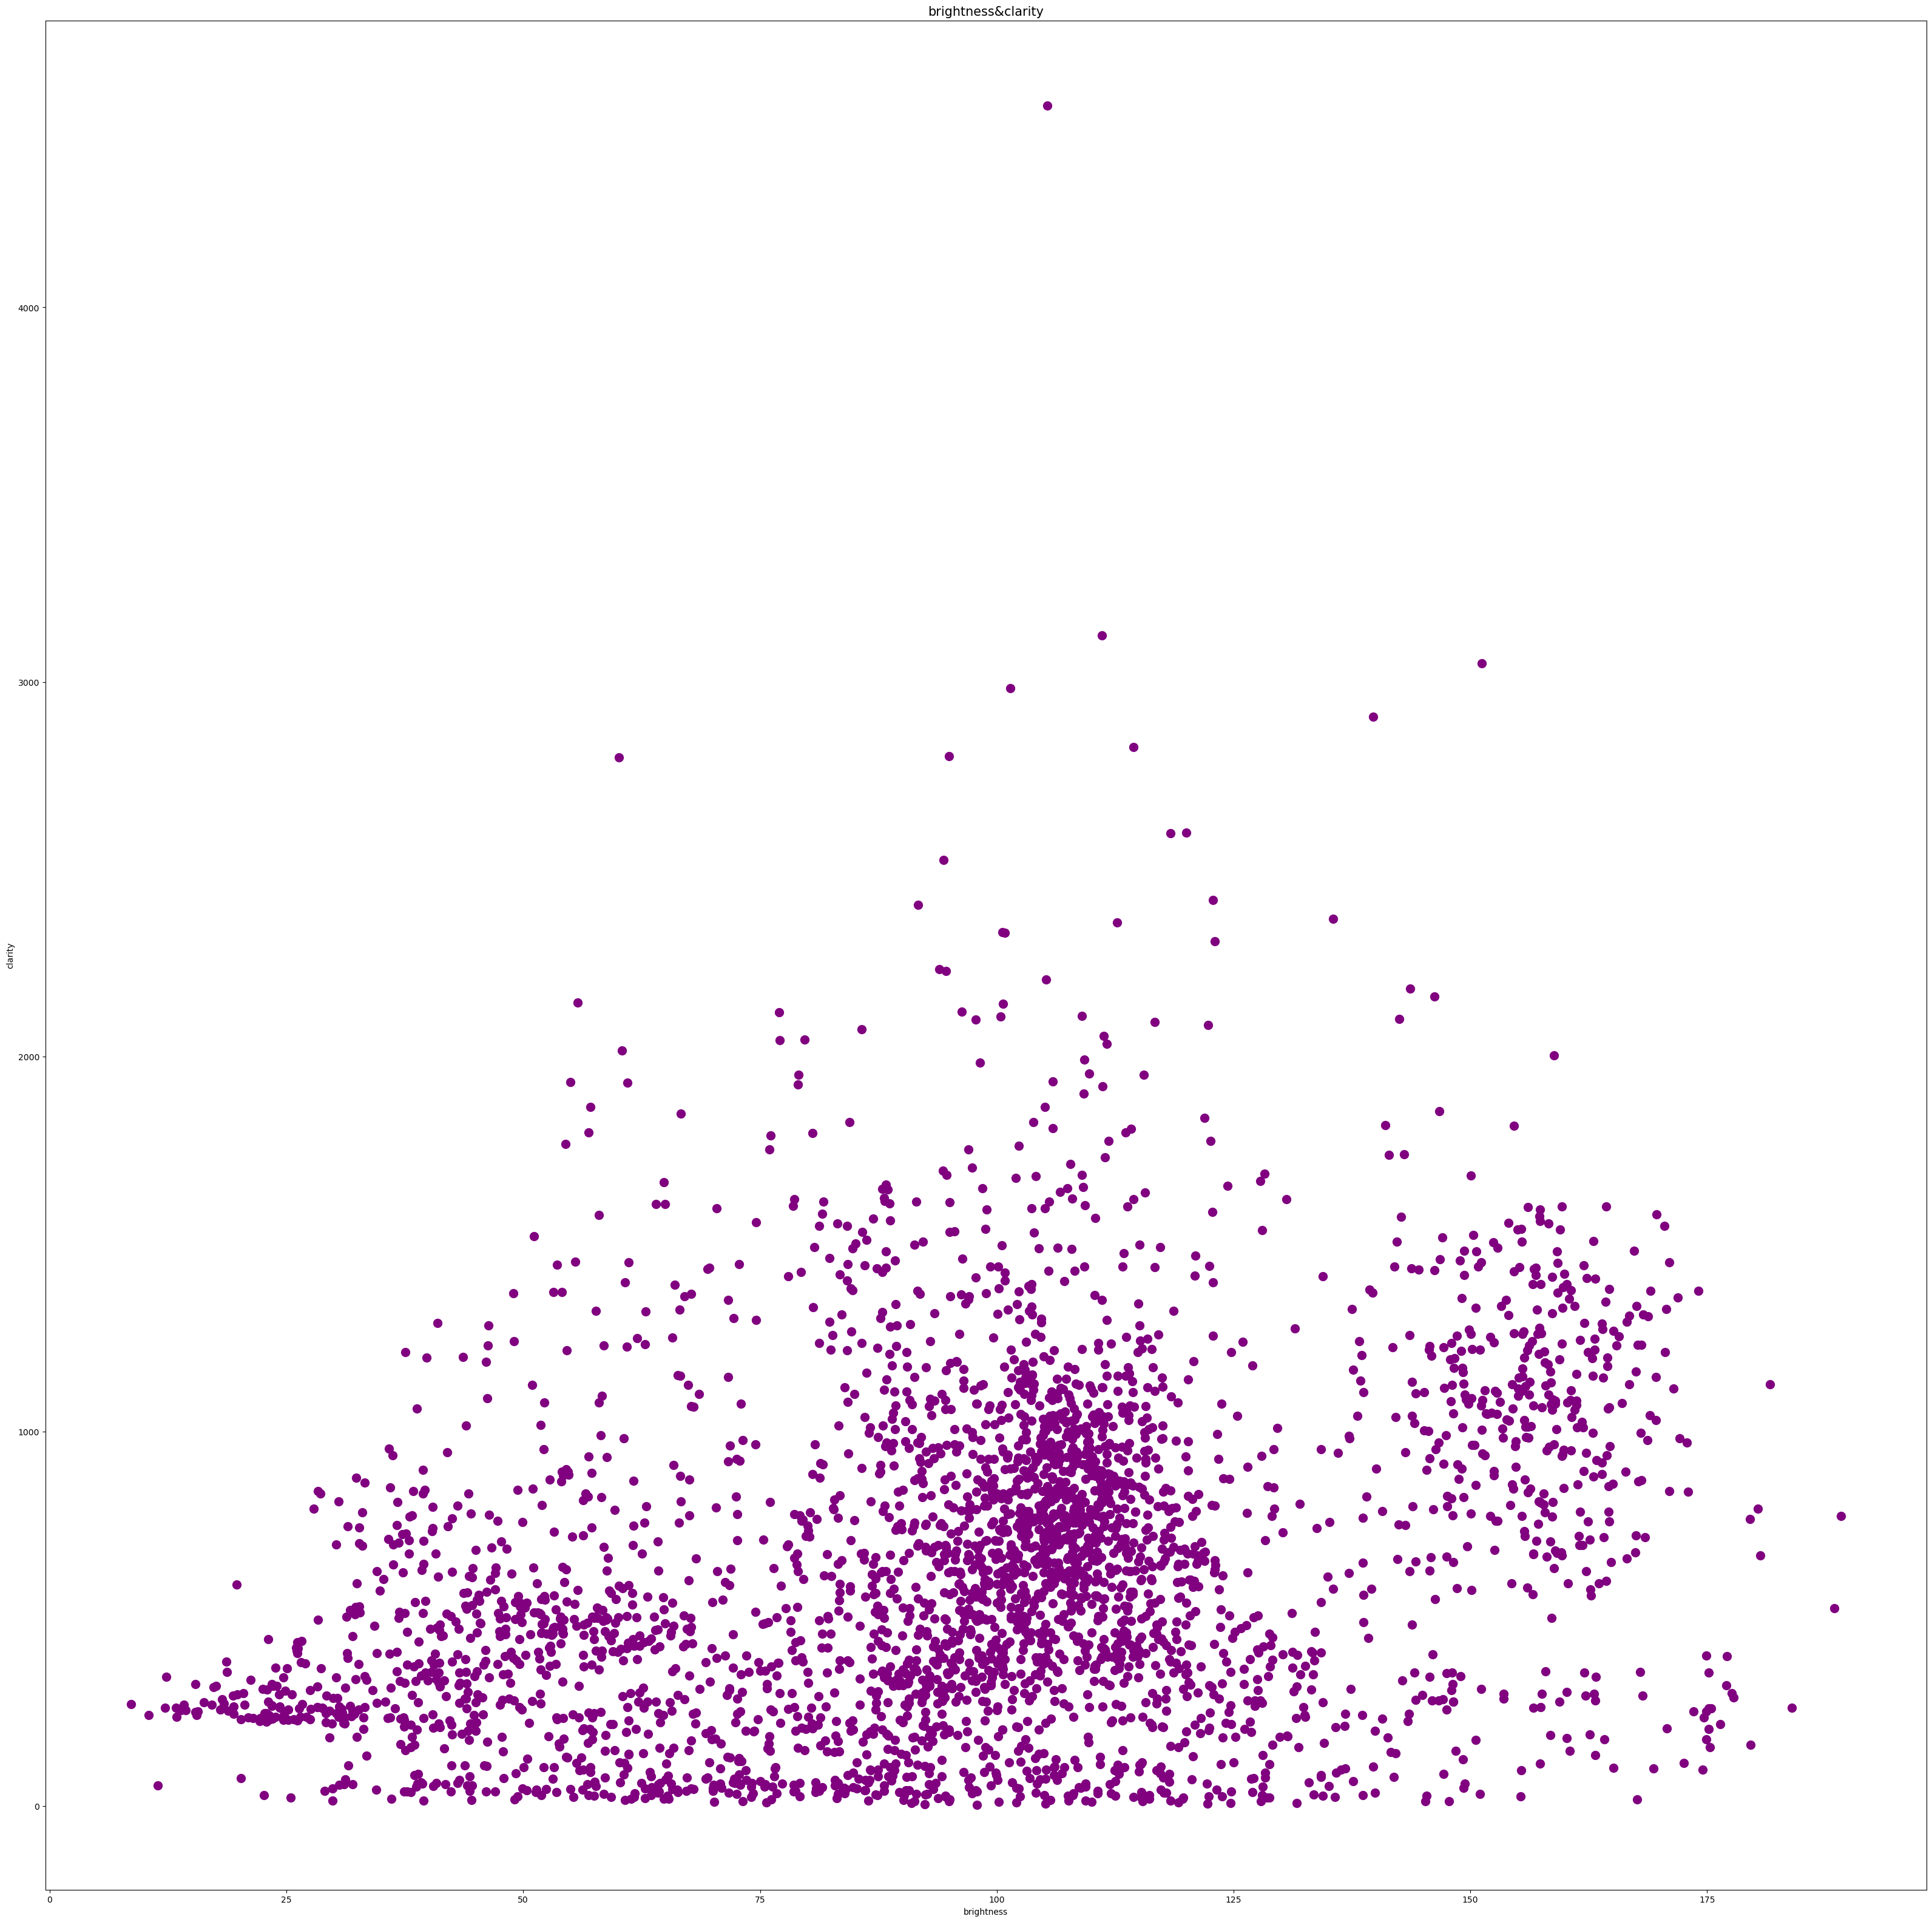

C:\Users\yvonna\AppData\Local\Temp\ipykernel_22448\302106372.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


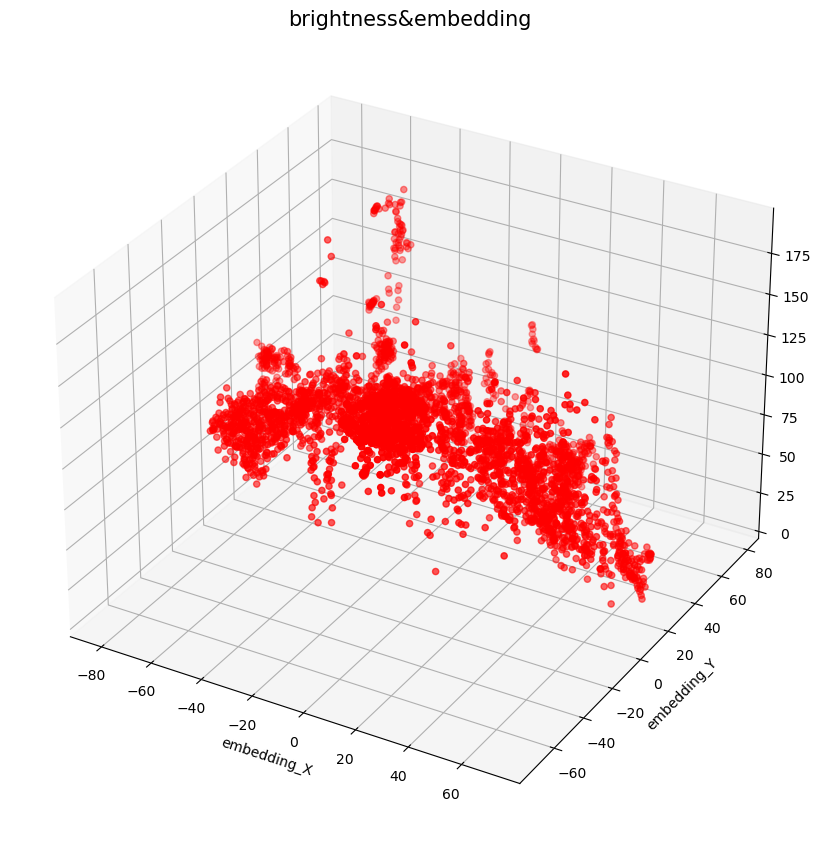

C:\Users\yvonna\AppData\Local\Temp\ipykernel_22448\302106372.py:66: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


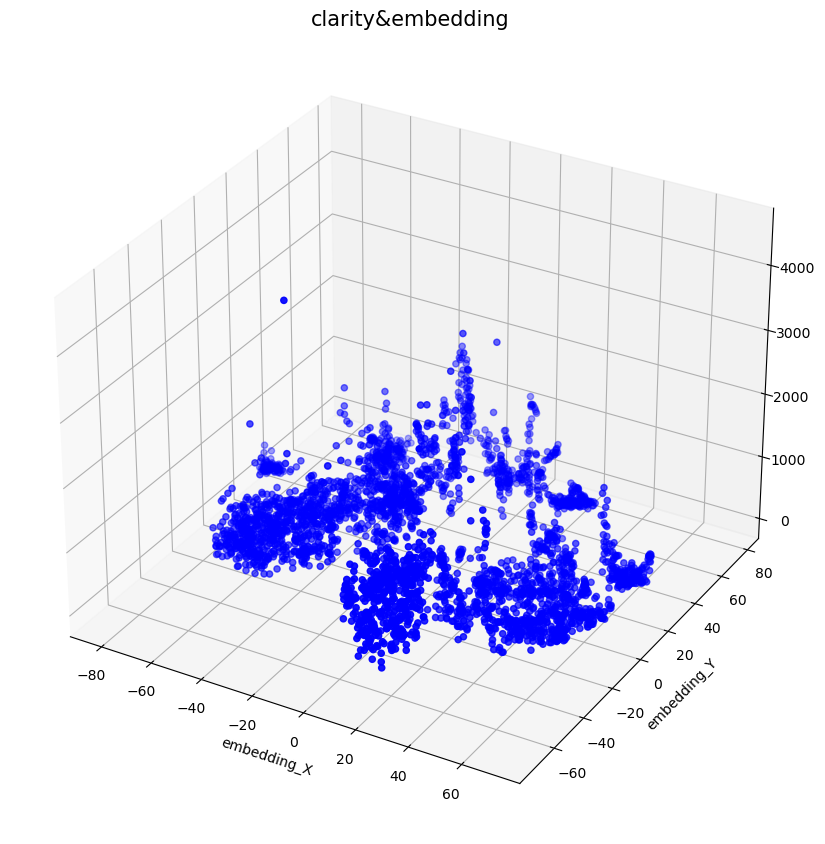

In [5]:
claritybright('C:/Users/yvonna/mai/rearview_together/img_delete.json', 'img_delete.csv')

In [35]:
def sceneweather(data, scene, weather):

    def restore(data):

        # load json data
        with open(data, newline='') as jsonfile:
            data = json.load(jsonfile)

        # trans image data to df
        images_df = []
        for item in data['images']:
            images_df.append(item)
        images_df = pd.DataFrame(images_df)

        #substr picture name out
        picture = []
        for i in range(len(images_df['file_name'])):
            pic = images_df['file_name'][i].split('/')
            picture.append(pic[-1])
        picture = pd.DataFrame(picture).rename(columns={0: 'name'})

        together = pd.merge(images_df, picture, left_index=True, right_index=True)

        name = together[['id', 'file_name', 'name']]
        
        return name


    def scene_4342(scene):

        # load json data
        with open(scene, newline='') as jsonfile:
            data = json.load(jsonfile)

        pred_class_df = []
        for item in data['pred_class']:
            pred_class_df.append(item)
        pred_class_df = pd.DataFrame(pred_class_df).rename(columns={0:'scene'})

        return pred_class_df


    def weather_4342(weather):

        # load json data
        with open(weather, newline='') as jsonfile:
            data = json.load(jsonfile)

        pred_class_df = []
        for item in data['pred_class']:
            pred_class_df.append(item)
        pred_class_df = pd.DataFrame(pred_class_df).rename(columns={0:'weather'})

        return pred_class_df

    together = pd.DataFrame().join([restore(data), scene_4342(scene)['scene'], weather_4342(weather)['weather']], how="outer")


    tunnel = 0
    residential = 0
    parking_lot = 0
    city_street = 0
    gas_stations = 0
    highway = 0
    undefine_scene = 0

    for i in range(len(together['scene'])):
        if 'tunnel' in str(together['scene'][i]):
            tunnel = tunnel + 1
        elif 'residential' in str(together['scene'][i]):
            residential = residential + 1
        elif 'parking lot' in str(together['scene'][i]):
            parking_lot = parking_lot + 1  
        elif 'city street' in str(together['scene'][i]):
            city_street = city_street + 1
        elif 'gas stations' in str(together['scene'][i]):
            gas_stations = gas_stations + 1    
        elif 'highway' in str(together['scene'][i]):
            highway = highway + 1      
        else:
            undefine_scene = undefine_scene + 1

    scene_dict = {
        'situation': ['tunnel', 'residential', 'parking lot', 'city street', 'gas stations', 'highway', 'undefined'],
        'count': [tunnel, residential, parking_lot, city_street, gas_stations, highway, undefine_scene]
    }    
    scene_df = pd.DataFrame(scene_dict)

    situation = ['tunnel', 'residential', 'parking lot', 'city street', 'gas stations', 'highway', 'undefined']
    count = [tunnel, residential, parking_lot, city_street, gas_stations, highway, undefine_scene]
    x = np.arange(len(situation))
    plt.bar(x, count, color=['darkslategrey', 'teal', 'lightseagreen', 'deepskyblue', 'aquamarine', 'cadetblue', 'steelblue'])
    plt.xticks(x, situation)
    plt.xlabel('situation')
    plt.ylabel('count')
    plt.title('scene')
    plt.show()



    rainy = 0
    snowy = 0
    clear = 0
    overcast = 0
    partly_cloudy = 0
    foggy = 0
    undefine_weather = 0

    for i in range(len(together['weather'])):
        if 'rainy' in str(together['weather'][i]):
            rainy = rainy + 1
        elif 'snowy' in str(together['weather'][i]):
            snowy = snowy + 1
        elif 'clear' in str(together['weather'][i]):
            clear = clear + 1  
        elif 'overcast' in str(together['weather'][i]):
            overcast = overcast + 1
        elif 'partly cloudy' in str(together['weather'][i]):
            partly_cloudy = partly_cloudy + 1    
        elif 'foggy' in str(together['weather'][i]):
            foggy = foggy + 1      
        else:
            undefine_weather = undefine_weather + 1
        
    weather_dict = {
        'situation': ['rainy', 'snowy', 'clear', 'overcast', 'partly cloudy', 'foggy', 'undefined'],
        'count': [rainy, snowy, clear, overcast, partly_cloudy, foggy, undefine_weather]
    }    
    weather_df = pd.DataFrame(weather_dict)

    situation = ['rainy', 'snowy', 'clear', 'overcast', 'partly cloudy', 'foggy', 'undefined']
    count = [rainy, snowy, clear, overcast, partly_cloudy, foggy, undefine_weather]
    x = np.arange(len(situation))
    plt.bar(x, count, color=['darkred', 'firebrick', 'brown', 'indianred', 'lightcoral', 'salmon', 'rosybrown'])
    plt.xticks(x, situation)
    plt.xlabel('situation')
    plt.ylabel('count')
    plt.title('weather')
    plt.show()


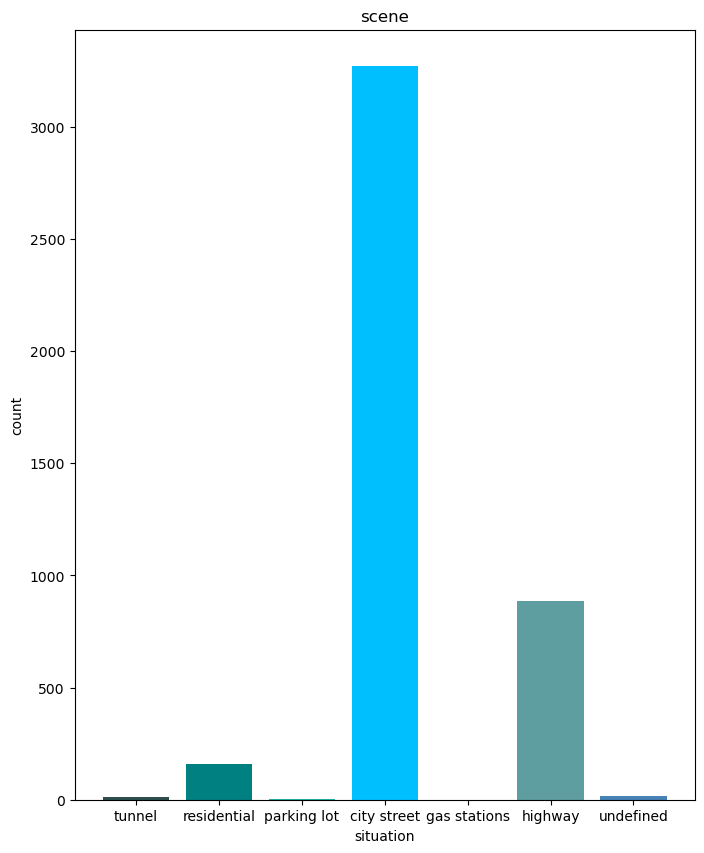

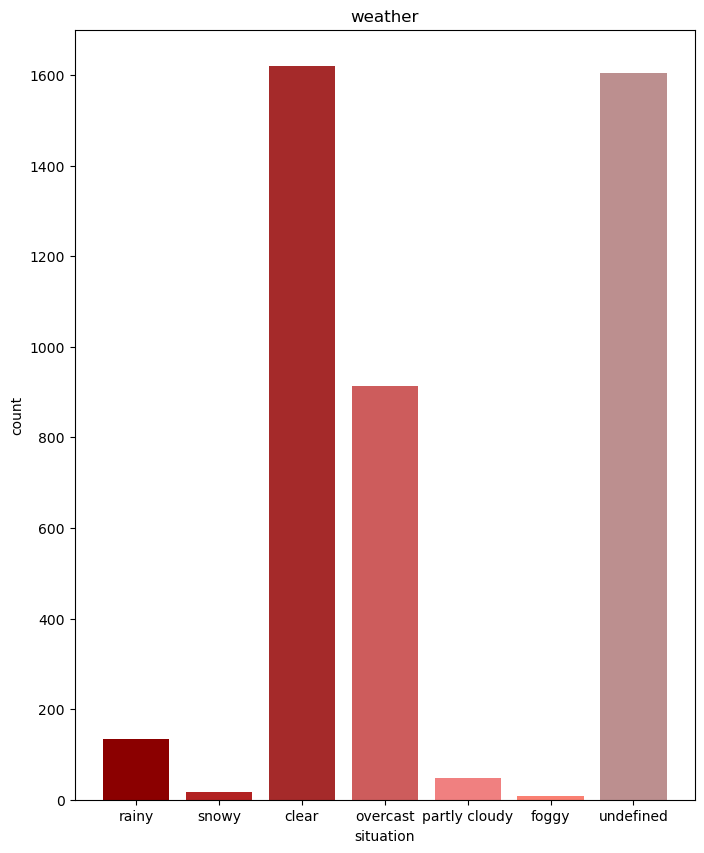

In [36]:
sceneweather('restore.json', 'C:/Users/yvonna/mai/scene_4326/preds.json', 'C:/Users/yvonna/mai/weather_4326/preds.json')